# Выпускной проект: Анализ профилей клиентов интернет-магазина

## Материалы:

* [Презентация](https://yadi.sk/i/OzNa6E_Rxa1IeQ)
* [Дашборд](https://public.tableau.com/app/profile/georgy6014/viz/-_16572857948220/Dashboard1?publish=yes)

## Цель проекта

На основе истории покупок определить сегменты покупателей с целью последующего улучшения персонализированных предложений для покупателей.

## Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Оглавление

1. [Определение функций](#Определение-функций)
2. [Предобработка данных](#Предобработка-данных)
    1. [Вывод](#s1_1)
3. [Исследовательский анализ данных (EDA)](#Исследовательский-анализ-данных-(EDA))
    1. [Вывод](#s2_1)
4. [Сегментация по среднему чеку](#Сегментация-по-среднему-чеку)
    1. [Вывод](#s3_1)
5. [Сегментация по частоте оформляемых заказов](#Сегментация-по-частоте-оформляемых-заказов)
    1. [Вывод](#s4_1)
6. [Сегментация по давности последнего оформленного заказа](#Сегментация-по-давности-последнего-оформленного-заказа)
    1. [Вывод](#s5_1)
7. [Сегментация по кумулятивному доходу, полученному с покупателя](#Сегментация-по-кумулятивному-доходу,-полученному-с-покупателя)
    1. [Вывод](#s6_1)
8. [Сегментация по категориям приобретаемых товаров](#Сегментация-по-категориям-приобретаемых-товаров)
    1. [Вывод](#s7_1)
9. [Проверка гипотез](#Проверка-гипотез)
    1. [Гипотеза №1. Средний чек клиентов, покупающих товары для дома, не равен среднему чеку клиентов, покупающих товары для сада](#Гипотеза-№1.-Средний-чек-клиентов,-покупающих-товары-для-дома,-не-равен-среднему-чеку-клиентов,-покупающих-товары-для-сада)
    2. [Гипотеза №2. Среднее количество приобретаемых товаров в заказе различается среди сегментов клиентов, которые делали заказы менее 2 раз и тех, кто делал заказы 2 и более количество раз](#Гипотеза-№2.-Среднее-количество-приобретаемых-товаров-в-заказе-различается-среди-сегментов-клиентов,-которые-делали-заказы-менее-2-раз-и-тех,-кто-делал-заказы-2-и-более-количество-раз)
    3. [Вывод](#s8_1)
10. [Итоговые выводы](#Итоговые-выводы)
    1. [Рекомендации](#Рекомендации)

## Определение функций

In [1]:
def get_stats(df, column, label, bins=10, h_lim=None, b_lim=None):
    """Эта функция будет выводить график распределения, "ящик с усами" и таблицу 
    со  статистическими показателями,  полученную методом describe().

    Функция может принимать следующие аргументы:
    'df' - датафрейм из которого мы будем выирать колонку со значениями
    'column' - название колонки из переданного ранее датафрейма
    'label' - текстовое описание колонки для подписи оси на графике
    'bins' - размер корзины для диаграммы распределения значений (по умолчанию - 10)
    'h_lim' - ограничение диаграммы распределения значений по горизонтальной 
        оси, передается в виде списка (по умолчанию - None)
    'b_lim' - ограничение "ящика с усами" по вертикальной 
        оси, передается в виде списка (по умолчанию - None)
    """
    
    # создадимполя для графиков
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    
    # отобразим гистограмму распределения по переданным данным
    df[column].hist(bins=bins, ax=axs[0])
    axs[0].set_title('Гистограмма распределения значений по колонке ' + column)
    axs[0].set_xlabel(label)
    axs[0].set_ylabel('Частота')
    if h_lim != None:
        axs[0].set_xlim(h_lim)
    
    # отобразим "ящик с усами" для переданных данных
    sns.boxplot(data=df, y=column, ax=axs[1])
    axs[1].set_title('"Ящик с усами" по колонке ' + column)
    axs[1].set_ylabel(label)
    if b_lim != None:
        axs[1].set_ylim(b_lim)
        
    # выведем графики    
    plt.show()
    
    # выведем таблицу со статистическими показателями
    print('Статистические показатели по колонке ' + column)
    display(df[column].describe().to_frame())
    
    
def save_segment(value, segments):
    """Эта функция будет распределять клиентов по сегментам  на основе переданных границ.
    Названия сегментов будут составляться исходя из значений границ сегментов.

    Функция может принимать следующие аргументы:
    'value' - значение колонки, по которой будет определяться сегмент клиента
    'segments' - значения границ сегментов, по которым происходит разделение на сегменты, передается в виде спика
    
    Например, если в segments мы передали список [10, 20, 60], то будет создано 4 сегмента:
    - '< 10'
    - '10 - 20'
    - '20 - 60'
    - '> 60'
    """
    # пройдем по всем значениям границ сегментов из списка segments
    # и определим к какому сегменту относится переданное значение value
    for i in range(len(segments)):
        if value < segments[i]:
            if i == 0:
                return '< ' + str(int(segments[i]))
            else:
                return str(int(segments[i - 1])) + ' - ' + str(int(segments[i]))
    return '> ' + str(int(segments[-1]))

## Предобработка данных

In [2]:
# импортиуем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from urllib.parse import urlencode
import requests
from pymystem3 import Mystem
from scipy import stats as st

# настроим отображение значений в датафреймах
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

Импортируем `csv` файл с исходными данными, который лежит по пути `https://disk.yandex.ru/d/kJwc3szk7vzv_g`.

In [3]:
# укажем ссылку для загрузки файла с помощью API
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# укажем ссылку на наши данные
public_key = 'https://disk.yandex.ru/d/kJwc3szk7vzv_g'

# сгенерируем финальную ссылку для получения файла через API
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [4]:
# сохраним данные файла в датафрейм
ecom_df = pd.read_csv(download_url)

# выведем первые 5 строк
ecom_df.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [5]:
# выведем общую информацию по датасету
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


- В датасете имеется `6737` значений. 
- Пропуски в данных отсутствуют.
- Типы данных указаны корректно, но колонку `date` стоит перевести в формат даты и времени.
- Заголовки  колонок прописаны корректно.

В колонке `date` мы имеем целочисленные значения, которые нам необходимо перевести в фоормат даты и времени. Исходя из имеющихся значений можно предположить, что данные в этой колонке были сохранены в формате `timestamp`. Попробуем перевести их в дату, учитывая данную гипотезу.

In [6]:
# меняем формат значений колонки `date`
pd.to_datetime(ecom_df['date'], unit='s')

0      2033-12-13 15:21:40
1      2033-12-13 15:21:40
2      2033-12-13 15:21:40
3      2033-12-13 15:21:40
4      2033-12-13 15:21:40
               ...        
6732   2033-12-25 05:58:31
6733   2033-12-25 05:58:32
6734   2033-12-25 05:58:33
6735   2033-12-25 05:58:34
6736   2033-12-25 05:58:36
Name: date, Length: 6737, dtype: datetime64[ns]

Мы получили очень странные даты - из будущего. Скорее всего в колонке `date` значения хранятся не в `timestamp`.  
Если присмотреться к значениям, то можно заметить, что даты будто бы были сохранены без разделителей. Попробуем поменять формат,  учитывая этот вариант.

In [7]:
# меняем формат значений колонки `date`
pd.to_datetime(ecom_df['date'], format='%Y%m%d%H')

0      2018-10-01 00:00:00
1      2018-10-01 00:00:00
2      2018-10-01 00:00:00
3      2018-10-01 00:00:00
4      2018-10-01 00:00:00
               ...        
6732   2019-10-31 11:00:00
6733   2019-10-31 12:00:00
6734   2019-10-31 13:00:00
6735   2019-10-31 14:00:00
6736   2019-10-31 16:00:00
Name: date, Length: 6737, dtype: datetime64[ns]

Эта гипотеза кажется верной. Сохраним формат в колонке `date`.

In [8]:
# меняем формат значений колонки `date`
ecom_df['date'] = pd.to_datetime(ecom_df['date'], format='%Y%m%d%H')

# создадим колонки с годом и месяцем заказа
ecom_df['year'] = ecom_df['date'].dt.year
ecom_df['month'] = ecom_df['date'].to_numpy().astype('datetime64[M]')

In [9]:
# проверим датасет на наличие "явных" дублей
ecom_df.duplicated().sum()

0

"Явные" дубли отсутствуют в датасете.

Проверим наличие дублей по дате заказа, ID клиента, ID заказа и назаванию товара в заказе.

In [10]:
ecom_df[['date', 'customer_id', 'order_id', 'product']].duplicated().sum()

0

Тут тоже не находим дублей.

Проверим на наличие дублей по тем же колонкам, но без даты.

In [11]:
ecom_df[['customer_id', 'order_id', 'product']].duplicated().sum()

1886

У нас получилось много дублей. Т.е. в датасете имеются случаи, при которых один и тот же клиент делал несколько заказов с одним и тем же ID и с одним и тем же товаром. Такая ситуация выглядит странно.

Посмотрим на такие заказы.

In [12]:
# отфильтруем заказы с дублями по колонкам 'customer_id', 'order_id' и 'product'
ecom_df[ecom_df[['customer_id', 'order_id', 'product']].duplicated()]

,date,customer_id,order_id,product,quantity,price,year,month
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0,2018,2018-10-01
...,...,...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-10-01
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0,2019,2019-10-01
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019,2019-10-01
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019,2019-10-01


Взглянем отдельно на несколько таких заказов.

In [13]:
ecom_df[ecom_df['order_id'] == 68474]

,date,customer_id,order_id,product,quantity,price,year,month
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,3299.0,2018,2018-10-01


In [14]:
ecom_df[ecom_df['order_id'] == 73108]

,date,customer_id,order_id,product,quantity,price,year,month
6704,2019-10-28 08:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0,2019,2019-10-01
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0,2019,2019-10-01


In [15]:
ecom_df[ecom_df['order_id'] == 70960]

,date,customer_id,order_id,product,quantity,price,year,month
2589,2019-04-01 16:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2600,2019-04-02 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2622,2019-04-03 08:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2718,2019-04-07 15:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2734,2019-04-08 09:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2762,2019-04-09 19:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2815,2019-04-12 22:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2820,2019-04-13 21:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2845,2019-04-14 17:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01
2854,2019-04-15 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019,2019-04-01


Действительно, выглядит очень странно: клиент сделал один и тот же заказ в разное время или же в разные дни на один и тот же товар. Например, заказ `68474`, мы имеем 6 дублей с одним и тем же товаром - `Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W`. Это явно не тот товар, который можно заказывать каждый день.

Предположим, что это техническая ошибка и попробуем узнать какое количество записей имеется для каждого такого заказа.

In [16]:
(
    ecom_df[ecom_df[['customer_id', 'order_id', 'product']].duplicated()]
    .groupby('order_id')['product']
    .agg('count')
    .sort_values(ascending=False)
    .to_frame()
)

,product
order_id,
14833,876
14835,174
14753,60
70960,59
14897,37
...,...
70647,1
70721,1
70726,1


У заказа с ID `14833` в таблице имеется `876` записей, что составляет чуть больше `1%` от общего количества записей. Если мы предполагаем, что подобные дубли это техническая ошибка, то при дальнейшем анализе мы можем получить более оптимистичные результаты, чем есть на самом деле, присвоив одним и тем же клиентам больше продаж, чем они совершили фактически.  
Хоть доля таких записей достаточно большая и составляет `27%`, но лучше получить чуть менее реалистичные прогнозы, чем чересчур оптимистичные.  
Оснований предполагать, что в дубли попали разные заказы, у нас нет, поэтому правильнее будет избавиться от таких дублей, оставив только самую первую запись с самой ранней датой для каждого заказа и сообщить о подобных ситуациях технической поддержке. 

Возможно, мы получим комментарии от тех.поддержки, которые позволят нам подправить данное исследование в дальнейшем.

In [17]:
# удаляем дубли из датасета
clean_ecom_df = (
    ecom_df.groupby(['customer_id', 'order_id', 'product', 'quantity', 'price'])
    .agg({'date': 'first', 'year': 'first', 'month': 'first'})
    .reset_index()
)

Проверим может ли повторяться ID заказа у разных клиентов.

In [18]:
(
    clean_ecom_df.groupby(['order_id'])['customer_id']
    .agg('nunique')
    .sort_values(ascending=False)
    .value_counts()
)

1    2755
2      26
3       2
4       1
Name: customer_id, dtype: int64

Мы имеем 29 случаев, когда один и тот же номер заказа был присвоен разным клиентам. Стоит уточнить у технических специалистов, из-за чего могла возникнуть такая ситуация, т.к. это похоже больше на техническую ошибку.  
В любом случае таких ситуаций не много и проще будет исключить их из анализа.

In [19]:
# создадим список с ID заказов, которые были присвоены более, чем 1 клиенту
bad_order_ids = list(
    clean_ecom_df.groupby(['order_id'])['customer_id']
    .agg('nunique')
    .sort_values(ascending=False)
    .reset_index()
    .query('customer_id > 1')['order_id']
)

# отфильтруем изначальный датасет и исключим проблемные заказы
# перезапишем исходный датасет
clean_ecom_df = clean_ecom_df[~clean_ecom_df['order_id'].isin(bad_order_ids)].reset_index()

# удалим колонку с индексом
clean_ecom_df.drop(columns='index', inplace=True)

Посмотрим на распределение ID заказов. Построим гистограмму.

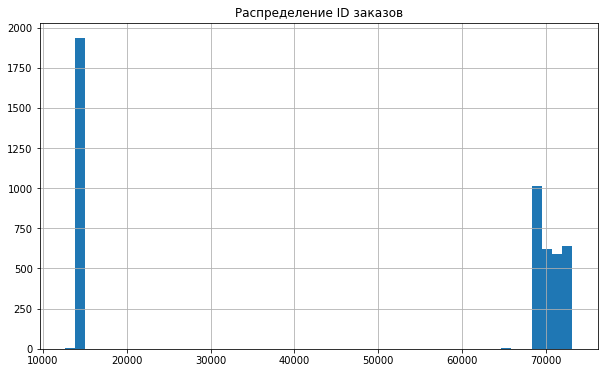

In [20]:
plt.figure(figsize=(10, 6))
clean_ecom_df['order_id'].hist(bins=50)
plt.title('Распределение ID заказов')
plt.show()

На гистограмме мы видим, что часть ID заказов находится в диапазоне от 0 до 20000, а часть в диапазоне от 60000 и выше. Между этими двумя диапазонами ID заказов отсутствуют. Изучим подробнее из-за чего происходит такое разделение ID заказов.

In [21]:
# выведем заказы с ID меньше 30000

clean_ecom_df[clean_ecom_df['order_id'] < 30000]

,customer_id,order_id,product,quantity,price,date,year,month
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1,150.0,2019-10-16 08:00:00,2019,2019-10-01
1,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония розебудная Queen Ingrid укорененный черенок,1,135.0,2019-10-16 08:00:00,2019,2019-10-01
2,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония розебудная Rosebud Red d-7 см,1,135.0,2019-10-16 08:00:00,2019,2019-10-01
3,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония тюльпановидная EMMA,1,135.0,2019-10-16 08:00:00,2019,2019-10-01
19,0184f535-b60a-4914-a982-231e3f615206,14566,Пеларгония розебудная Margaretha укорененный черенок,1,135.0,2019-03-07 10:00:00,2019,2019-03-01
...,...,...,...,...,...,...,...,...
4729,fb117193-682f-44ab-b9fe-e9be18801e36,14580,Пеларгония розебудная Queen Ingrid укорененный черенок,1,135.0,2019-03-18 19:00:00,2019,2019-03-01
4730,fb117193-682f-44ab-b9fe-e9be18801e36,14580,Пеларгония розебудная Red Pandora укорененный черенок,1,135.0,2019-03-18 19:00:00,2019,2019-03-01
4773,fc9641ba-8f74-45de-a60a-342d2e0dd7af,14794,томата (помидор) Земляника оранжевая №31 сорт индетерминантный среднеспелый оранжевый,2,38.0,2019-05-19 13:00:00,2019,2019-05-01
4774,fc9641ba-8f74-45de-a60a-342d2e0dd7af,14794,томата (помидор) Король красоты №46 сорт индетерминантный среднеспелый оранжевый,2,38.0,2019-05-19 13:00:00,2019,2019-05-01


In [22]:
# выведем минимальную и максимальную даты заказов

print(clean_ecom_df[clean_ecom_df['order_id'] < 30000]['date'].min())
print(clean_ecom_df[clean_ecom_df['order_id'] < 30000]['date'].max())

2018-10-02 11:00:00
2019-10-22 13:00:00


In [23]:
# выведем заказы с ID больше 30000

clean_ecom_df[clean_ecom_df['order_id'] > 30000]

,customer_id,order_id,product,quantity,price,date,year,month
4,001cee7f-0b29-4716-b202-0042213ab038,70290,Сушилка для белья потолочная ЛИАНА ЛЮКС 150 см ЛЛП-150,1,442.0,2019-02-16 11:00:00,2019,2019-02-01
5,00299f34-5385-4d13-9aea-c80b81658e1b,72965,"Ткань для окон Duo для влажной и сухой чистки 200*200 мм, Leifheit, 40002",2,457.0,2019-10-14 23:00:00,2019,2019-10-01
6,002d4d3a-4a59-406b-86ec-c3314357e498,69990,Сумка-тележка 2-х колесная складная Gimi Flexi серая,1,1649.0,2019-01-27 17:00:00,2019,2019-01-01
7,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,Стеллаж для обуви TELIO-370 венге OPT-370V,2,1162.0,2019-09-29 17:00:00,2019,2019-09-01
8,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,69987,Вешалка-перекладина Valiant металлическая двойная с антискользящим покрытием 50320,12,128.0,2019-01-27 12:00:00,2019,2019-01-01
...,...,...,...,...,...,...,...,...
4802,ff601403-b094-4b86-9ac6-264d725b9277,72313,Сумка-тележка 2-х колесная складная Gimi Flexi зеленая,1,1649.0,2019-08-16 16:00:00,2019,2019-08-01
4803,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019-10-30 07:00:00,2019,2019-10-01
4804,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,69369,Новогоднее дерево Ель канадская Коника ртк 343 d-9 см,1,389.0,2018-12-14 23:00:00,2018,2018-12-01
4805,ffb80538-3fda-4351-8ea9-9d2bec58bb07,72561,"Стакан для ванной комнаты ETNA SHINY керамика 12,5х9,5 см коричневый, Spirella, 1016116",1,974.0,2019-09-09 12:00:00,2019,2019-09-01


In [24]:
# выведем минимальную и максимальную даты заказов

print(clean_ecom_df[clean_ecom_df['order_id'] > 30000]['date'].min())
print(clean_ecom_df[clean_ecom_df['order_id'] > 30000]['date'].max())

2018-10-01 00:00:00
2019-10-31 14:00:00


In [25]:
# выведем заказы с ID между 15000 и 60000

clean_ecom_df[(clean_ecom_df['order_id'] < 60000) & (clean_ecom_df['order_id'] > 15000)]

,customer_id,order_id,product,quantity,price,date,year,month
2948,a20fa81f-233b-434b-90a2-5c8f80dd2119,56879,"Банка из стекла для сыпучих продуктов круглой с пластмассовой крышкой и цветной вкладкой 1,0л 10МР-0001",5,52.0,2018-11-27 19:00:00,2018,2018-11-01


Какой-то разницы в периодах у заказов с ID из разных диапазонов нет. Возможно, дело в товарах - для определенного сегмента товаров ведется свой диапазон ID заказов.
Проверим это посчитав уникальное количество наименований в двух диапазонах и сравнив с количеством уникальных наименований по всему датасету.

In [26]:
# сумма количества уникальных наименований из двух диапазонов
(
    len(clean_ecom_df[clean_ecom_df['order_id'] < 30000]['product'].unique()) 
    + len(list(clean_ecom_df[clean_ecom_df['order_id'] > 30000]['product'].unique()))
)

2342

In [27]:
# количество уникальных наименований во всем датасете
len(list(clean_ecom_df['product'].unique()))

2331

Сумма наименований из двух диапазонов отличается от общей суммы  наименований на 11 позиций, что явно указывает на различия между содержимым заказов с ID заказов из одного диапазона и из другого.

Посмотрим на списки содержимых заказов по каждому диапазону.

In [28]:
# содержимое заказов с ID меньше 30000

list(clean_ecom_df[clean_ecom_df['order_id'] < 30000]['product'].unique())

['Пеларгония зональная диам. 12 см темнорозовая полумахровая',
 'Пеларгония розебудная Queen Ingrid укорененный черенок',
 'Пеларгония розебудная Rosebud Red d-7 см',
 'Пеларгония тюльпановидная EMMA',
 'Пеларгония розебудная Margaretha укорененный черенок',
 'Пеларгония розебудная Mary укорененный черенок',
 'Пеларгония розебудная Prins Nikolai укорененный черенок',
 'Пеларгония розебудная Red Pandora укорененный черенок',
 'Рассада Капусты белокачанная поздняя Лидер, кассета по 10шт',
 'Рассада Тыквы сорт Мускаде горшок 9х9 см P-9',
 'Рассада перца болгарского сладкого Красное чудо, горшок диам 12',
 'Рассада томата (помидор) Джессика № 50 сорт индетерминантный раннеспелый красный',
 'Рассада томата (помидор) Сладкий Касади №76 сорт индетерминантный среднеспелый оранжевый',
 'Рассада томата (помидор) Суперэкзотик № 109 сорт индетерминантный среднеспелый черный',
 'Рассада томата (помидор) сорт Аделина, горшок диам 12',
 'Рассада томата (помидор) сорт Де Барао золотой',
 'Рассада тома

In [29]:
# содержимое заказов с ID больше 30000

list(clean_ecom_df[clean_ecom_df['order_id'] > 30000]['product'].unique())

['Сушилка для белья потолочная ЛИАНА ЛЮКС 150 см ЛЛП-150',
 'Ткань для окон Duo для влажной и сухой чистки 200*200 мм, Leifheit, 40002',
 'Сумка-тележка 2-х колесная складная Gimi Flexi серая',
 'Стеллаж для обуви TELIO-370 венге OPT-370V',
 'Вешалка-перекладина Valiant металлическая двойная с антискользящим покрытием 50320',
 'Штора для ванной комнаты Quadretto 240х200 см белая, Bacchetta, 4062',
 'Чехол для гладильной доски UNIVERSAL 160х60 см, Attribute, ABU004',
 'Пеларгония розебудная Mary укорененный черенок',
 'Пеларгония Toscana Angeleyes Bicolor укорененный черенок',
 'Коврик придверный PHP SRL 40х68 см Format Mezzaluna 20826 Узор 5374',
 'Сушилка для белья напольная НИКА СБ8 18 м серая',
 'Вешалка напольная ФАНК ЛК-21 F/LK-21',
 'Сушилка для белья на стену Leifheit Rollquick до 4.2 м, белая, 83006',
 'Сушилка для белья Gimi Dinamik 30',
 'Сушилка для белья напольная НИКА СБП1/С 18 м',
 'Тарелка десертная Luminarc СИНА СИЛЬВЕР 19 см L0886',
 'Шпингалет 80 мм белый с пружиной, 

Исходя из полученных списков видно, что заказы с ID меньше 30000 относятся больше к тем, кто увлекается садоводством, а ID более 30000 к тем, кто покупает товары для обустройства дома.

Выведем общую информацию по предобработанному датасету.

In [30]:
clean_ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  4807 non-null   object        
 1   order_id     4807 non-null   int64         
 2   product      4807 non-null   object        
 3   quantity     4807 non-null   int64         
 4   price        4807 non-null   float64       
 5   date         4807 non-null   datetime64[ns]
 6   year         4807 non-null   int64         
 7   month        4807 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 300.6+ KB


<a id="s1_1"></a>

### Выводы

- В нашем датасете имеется `4807` значений. 
- Пропуски в данных отсутствуют. 
- Типы данных соотвтетсвуют значениям в колонках.
- Колонки озаглавлены корректно.
- Были выявлены дубли заказов и данные были очищены от дублей.

## Исследовательский анализ данных (EDA)

Начнем с изучения периода заказов в датасете. Определим минимальную и максимальную даты заказов.

In [31]:
print('Минимальная дата заказа: {}'.format(clean_ecom_df['date'].min()))
print('Максимальная дата заказа: {}'.format(clean_ecom_df['date'].max()))

Минимальная дата заказа: 2018-10-01 00:00:00
Максимальная дата заказа: 2019-10-31 14:00:00


В датасете имеются данные о заказах, совершенных с `1 октября 2018` по `31 октября 2019` года.

Изучим статистические показатели датасета.

In [32]:
clean_ecom_df.describe()

,order_id,quantity,price,year
count,4807.000000,4807.000000,4807.000000,4807.000000
mean,47989.490535,2.809861,514.866029,2018.746828
std,27384.511754,17.684361,946.464278,0.434874
min,12624.000000,1.000000,9.000000,2018.000000
25%,14770.000000,1.000000,90.000000,2018.000000
50%,68844.000000,1.000000,150.000000,2019.000000
75%,70796.500000,1.000000,488.000000,2019.000000
max,73164.000000,1000.000000,14917.000000,2019.000000


- Ниаменьший ID заказа в датасете - `12624`, а наибольший - `73164`.
- Не менее `75%` содержимого заказов приобретается в размере `1` штуки.
- Наименьшая цена за единицу содержимого в заказе наименования составляет `9 руб`, наибольшая - `14917 руб`. 
- Средняя цена единицы наименования из заказа составляет `514 руб`.
- Стоимость половины наименований из заказов не  превышает `150 руб`, а стоимость `75%` наименований не превышает `488 руб`.

Посмотрим на выбросы в значениях. Для этого построим "ящик с усами" для параметров `quantity` и `price`.

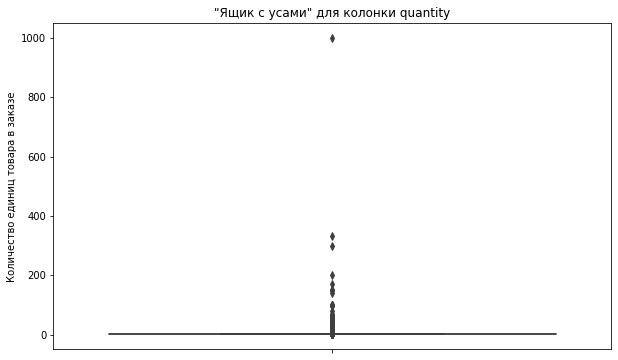

In [33]:
# строим "ящик с усами" для значений 'quantity'
plt.figure(figsize=(10, 6))
sns.boxplot(data=clean_ecom_df, y='quantity')
plt.title('"Ящик с усами" для колонки quantity')
plt.ylabel('Количество единиц товара в заказе')
plt.show()

Исходя из полученных данных методом `describe()` мы знаем, что основная масса значений лежит в области 1, при этом мы видим, что имеются сильные отклонения от основной массы значений. Из-за сильных отклонений мы и получили завышенное среднее значение по сравнению с медианным.

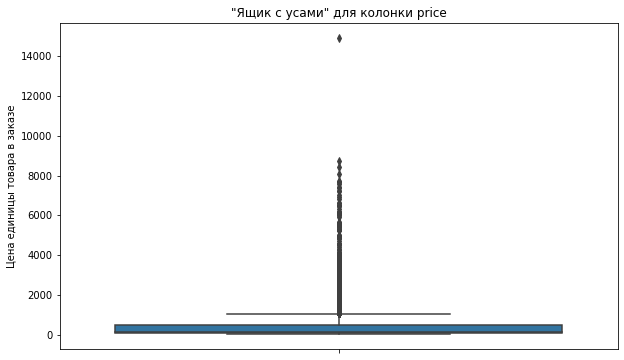

In [34]:
# строим "ящик с усами" для значений 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(data=clean_ecom_df, y='price')
plt.title('"Ящик с усами" для колонки price')
plt.ylabel('Цена единицы товара в заказе')
plt.show()

По колонке `price` тоже видно наличие сильных выбросов.

Изучим различные показатели по продажам.

Создадим таблицу с заказами, в которой сохраним дату заказа, год и месяц заказа, ID заказа, ID клиента, общее количество товаров в заказе и общую сумму заказа.

In [35]:
# посчитаем общую стоимость товара
clean_ecom_df['costs'] = clean_ecom_df['price'] * clean_ecom_df['quantity']

# создадим таблицу с заказами
orders = (
    clean_ecom_df.groupby(['date', 'year', 'month', 'customer_id', 'order_id'])
    .agg({'product': 'nunique', 'quantity': 'sum', 'costs': 'sum'})
    .reset_index()
)
orders.columns = ['date', 'year', 'month', 'customer_id', 'order_id', 
                  'products_quantity', 'total_quantity', 'total_costs']

# выведем первые 5 строк таблицы
orders.head(5)

,date,year,month,customer_id,order_id,products_quantity,total_quantity,total_costs
0,2018-10-01 00:00:00,2018,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,7,7,1037.0
1,2018-10-01 08:00:00,2018,2018-10-01,375e0724-f033-4c76-b579-84969cf38ee2,68479,1,1,824.0
2,2018-10-01 08:00:00,2018,2018-10-01,6644e5b4-9934-4863-9778-aaa125207701,68478,1,1,269.0
3,2018-10-01 09:00:00,2018,2018-10-01,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,1,1,674.0
4,2018-10-01 11:00:00,2018,2018-10-01,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483,1,10,820.0


In [36]:
# посчитаем общее количество заказов и клиентов
print('Общее количество записей в таблице: {}'.format(orders.shape[0]))
print('Общее количество заказов: {}'.format(len(orders['order_id'].unique())))
print('Общее количество покупателей: {}'.format(len(orders['customer_id'].unique())))

Общее количество записей в таблице: 2778
Общее количество заказов: 2755
Общее количество покупателей: 2394


Мы получили в новой таблице дубли заказов, т.к. уникальных заказов у нас меньше, чем строк в таблице.

Изучим дубли в имеющейся таблице.

In [37]:
orders[orders[['customer_id', 'order_id']].duplicated(keep=False)].sort_values(by=['date', 'order_id'])

,date,year,month,customer_id,order_id,products_quantity,total_quantity,total_costs
216,2018-10-28 08:00:00,2018,2018-10-01,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,9,9,1410.0
232,2018-10-31 06:00:00,2018,2018-10-01,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,1,1,101.0
514,2018-12-10 11:00:00,2018,2018-12-01,bbb32131-2d92-4c1e-aa28-41723f7bc26c,69282,1,6,264.0
576,2018-12-17 10:00:00,2018,2018-12-01,bbb32131-2d92-4c1e-aa28-41723f7bc26c,69282,1,12,528.0
648,2018-12-23 12:00:00,2018,2018-12-01,eb04c06f-bee9-45bd-9392-4addbc54952f,69527,1,1,712.0
671,2018-12-24 20:00:00,2018,2018-12-01,eb04c06f-bee9-45bd-9392-4addbc54952f,69527,1,1,1649.0
748,2019-01-09 14:00:00,2019,2019-01-01,d247211c-d16b-43ba-812d-6a27aff31871,69750,1,1,2999.0
774,2019-01-13 22:00:00,2019,2019-01-01,0982f6b9-328f-4a67-b7ee-cd0a114868f0,69807,1,1,59.0
798,2019-01-17 10:00:00,2019,2019-01-01,595c636d-2625-494f-8c98-b342bd4fbb9f,69861,1,1,134.0
799,2019-01-17 17:00:00,2019,2019-01-01,595c636d-2625-494f-8c98-b342bd4fbb9f,69861,1,1,239.0


In [38]:
# посмотрим выборочно историю заказа с дублем
clean_ecom_df[clean_ecom_df['order_id'] == 69527]

,customer_id,order_id,product,quantity,price,date,year,month,costs
4421,eb04c06f-bee9-45bd-9392-4addbc54952f,69527,Лестница-стремянка Dogrular Ufuk оцинкованная 8-ми ступенчатая,1,1649.0,2018-12-24 20:00:00,2018,2018-12-01,1649.0
4422,eb04c06f-bee9-45bd-9392-4addbc54952f,69527,Плед флисовый 200х150 см WELLNESS WPLNY152-Зима_4 100 % полиэстер,1,712.0,2018-12-23 12:00:00,2018,2018-12-01,712.0


У нас имеется один и тот же заказ, но который был зарегистрирован дважды. В заказе поменялся товар с `Лестница-стремянка Dogrular Ufuk оцинкованная 8-ми ступенчатая` на `Плед флисовый 200х150 см WELLNESS WPLNY152-Зима_4 100 % полиэстер`. Можно было бы предположить, что была произведена замена товара, который закончился и что из-за этого в данных появился дубль заказа с обновленным составом, но на текущем примере мы видим, что товары не являются заменителями друг друга. Вероятно, клиент решил добавить еще товара в заказ, но мы не знаем возможно ли что-либо добавлять в заказ после его оформления - это стоит уточнить у менеджеров интернет-магазина.

In [39]:
# посмотрим выборочно еще одну историю заказа с дублем
clean_ecom_df[clean_ecom_df['order_id'] == 71413]

,customer_id,order_id,product,quantity,price,date,year,month,costs
799,2c2f1c82-d5f8-462a-b3ea-8ab375a8fa0d,71413,Карниз для ванной комнаты Виолет раздвижной 280 см с кольцами бежевый 2810/2,1,224.0,2019-05-13 18:00:00,2019,2019-05-01,224.0
800,2c2f1c82-d5f8-462a-b3ea-8ab375a8fa0d,71413,Карниз для ванной комнаты Виолет раздвижной 280 см с кольцами бежевый 2810/2,2,224.0,2019-05-17 14:00:00,2019,2019-05-01,448.0


В данном случае изменилось количество товара в заказе, что похоже на наше второе предположение об изменении состава заказа после его оформления.

На данный момент мы наверняка не уверены, что это за случаи и как их интерпретировать. Количество таких дублей не так велико и для целей исследования можно исключить дули из датасета, оставив самые ранние заказы, как основные.

In [40]:
# избавимся от задублироованных заказов
orders = orders[~orders[['customer_id', 'order_id']].duplicated(keep='first')].reset_index()

# выведем размер датасета
orders.shape[0]

2755

Изучим новую таблицу методом `describe()`.

In [41]:
orders[['products_quantity', 'total_quantity', 'total_costs']].describe()

,products_quantity,total_quantity,total_costs
count,2755.000000,2755.000000,2755.000000
mean,1.732486,4.868966,1478.037024
std,2.806637,23.980397,13030.003632
min,1.000000,1.000000,14.000000
25%,1.000000,1.000000,284.500000
50%,1.000000,1.000000,680.000000
75%,1.000000,3.000000,1461.500000
max,51.000000,1000.000000,675000.000000


- `75%` заказов состоит из `1` товара. Наибольшее количество товаров в заказе равно `51`.
- Более половины заказов состоит из `1` единицы товара.
- Средняя стоимость заказа составляет `1478 руб`. Минимальная сумма заказа - `14 руб`, максимальная - `675000 руб`.
- Около половины заказов не превышает `680 руб`, а около `75%` заказов не превышает `1461 руб`.

Изучим выбросы с помощью "ящика с усами".

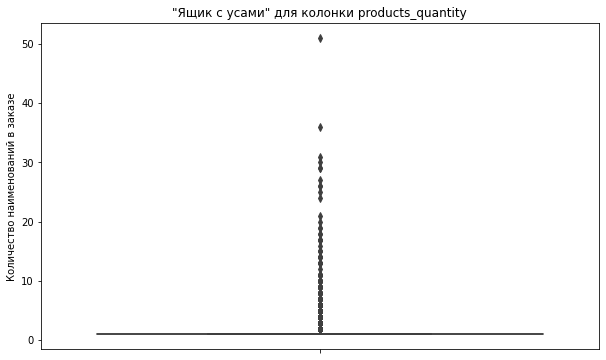

In [42]:
# строим "ящик с усами" для значений 'products_quantity'
plt.figure(figsize=(10, 6))
sns.boxplot(data=orders, y='products_quantity')
plt.title('"Ящик с усами" для колонки products_quantity')
plt.ylabel('Количество наименований в заказе')
plt.show()

Видим большое количество выбросов и что основная масса значений находится в области 1.

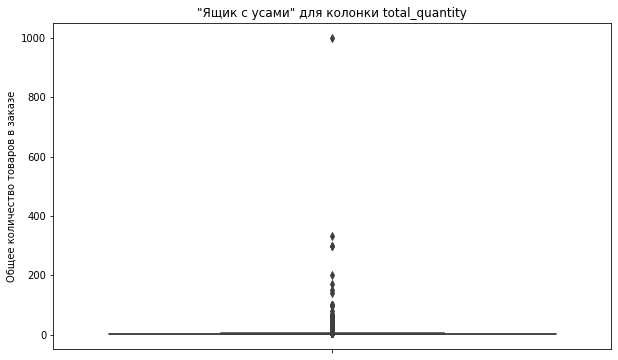

In [43]:
# строим "ящик с усами" для значений 'total_quantity'
plt.figure(figsize=(10, 6))
sns.boxplot(data=orders, y='total_quantity')
plt.title('"Ящик с усами" для колонки total_quantity')
plt.ylabel('Общее количество товаров в заказе')
plt.show()

По данной колонке мы также видим очень большое количество выбросов и достаточно сильных.  
Так же есть весьма сильный выброс в районе 1000 наименований в заказе.

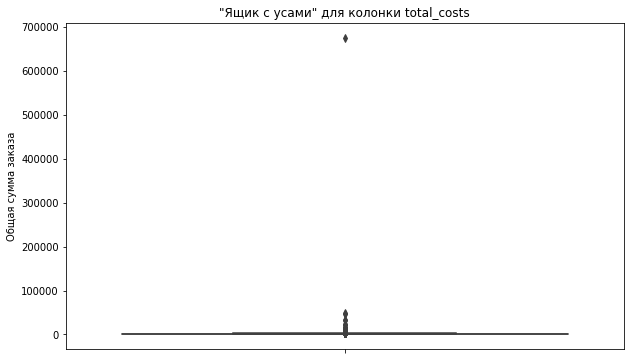

In [44]:
# строим "ящик с усами" для значений 'total_costs'
plt.figure(figsize=(10, 6))
sns.boxplot(data=orders, y='total_costs')
plt.title('"Ящик с усами" для колонки total_costs')
plt.ylabel('Общая сумма заказа')
plt.show()

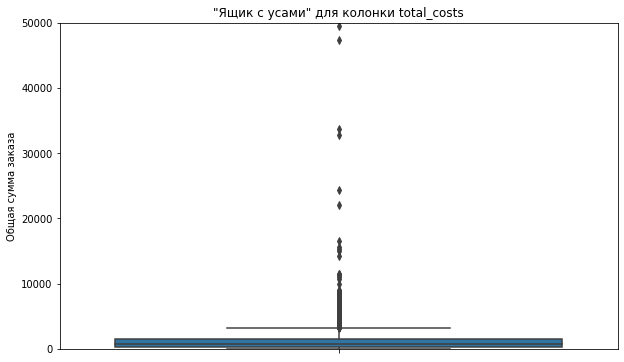

In [45]:
# строим "ящик с усами" для значений 'total_costs'
plt.figure(figsize=(10, 6))
sns.boxplot(data=orders, y='total_costs')
plt.ylim(0, 50000)
plt.title('"Ящик с усами" для колонки total_costs')
plt.ylabel('Общая сумма заказа')
plt.show()

В данном случае мы видим очень сильный выброс в районе `700000`. Скорее всего был какой-то один заказ, который и создает настолько сильный выброс по всем колонкам. Отфильтруем датасет, чтобы избавить от этого заказа, чтобы избежать искажений в исследовании.

In [46]:
# избавимся от заказа, который создает сильный выброс
orders = orders[orders['total_costs'] < 500000]

Посчитаем общее количество продаж по месяцам и годам.

In [47]:
# создадим таблицу с количеством и суммой заказов по месяцам
orders_dynamic = (
    orders.groupby(['year', 'month'])
    .agg({'order_id': 'count', 'total_costs': 'sum'})
    .reset_index()
)

# выведем таблицу
orders_dynamic

,year,month,order_id,total_costs
0,2018,2018-10-01,238,351061.0
1,2018,2018-11-01,204,359348.0
2,2018,2018-12-01,278,344272.0
3,2019,2019-01-01,165,230097.0
4,2019,2019-02-01,284,299074.0
5,2019,2019-03-01,242,249429.0
6,2019,2019-04-01,264,315451.0
7,2019,2019-05-01,178,231925.0
8,2019,2019-06-01,156,225116.0
9,2019,2019-07-01,198,234812.0


Построим график динамики продаж в денежном выражении по месяцам.

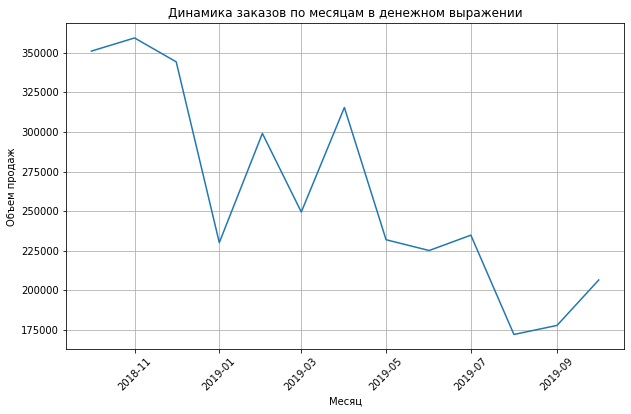

In [48]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=orders_dynamic, x='month', y='total_costs')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж')
plt.xticks(rotation=45)
plt.grid()
plt.title('Динамика заказов по месяцам в денежном выражении')
plt.show()

Как видно из графика продажи за год сильно упали с `351000 руб` до `206000 руб`.  
Заметно сильное падение продаж в январе до `230000 руб`, после чего продажи немного выросли до `315000 руб` в апреле. С апреля же заметно стабильное падение продаж, что может быть связано с летним сезоном. Стоит посмотреть на динамику с учетом полученных на данный момент сегментов: садоводов и клиентов, покупающих вещи для дома.

Добавим в таблицу колонку `order_type` со значениями `garden` и `home`.

In [49]:
# создадим катгории по типам заказов
orders['order_type'] = orders['order_id'].apply(lambda x: 'garden' if x < 50000 else 'home')

# пересоздадим таблицу с динамикой заказов
orders_dynamic = (
    orders.groupby(['year', 'month', 'order_type'])
    .agg({'order_id': 'count', 'total_costs': 'sum'})
    .reset_index()
)

Построим график динамики заказов с разбивкой по типам заказов.

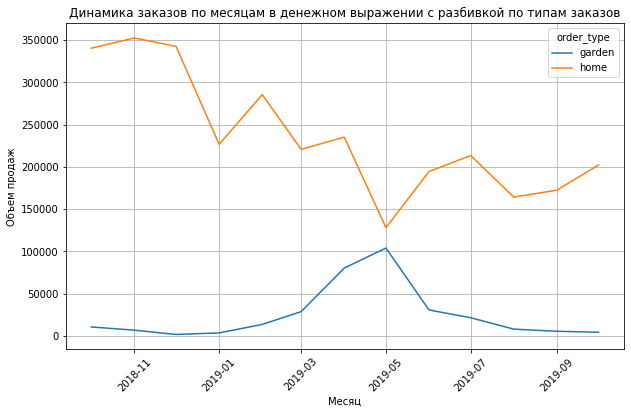

In [50]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=orders_dynamic, x='month', y='total_costs', hue='order_type')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж')
plt.xticks(rotation=45)
plt.grid()
plt.title('Динамика заказов по месяцам в денежном выражении с разбивкой по типам заказов')
plt.show()

Теперь мы видим, что увеличение продаж с апреля месяца связано с увеличением активности садоводов, т.к. в апреле-мае начинается сезон садоводства. По продаже товаров для дома заметен тренд спада продаж, что может быть связано с тем, что заметное увеличение роста продаж товаров для дома приходится на самый конец года, в период праздников.

Изучим долю продаж по типам заказов.

In [51]:
# создадим колонку для объединения всех заказов
orders['group_all'] = 'all_orders'

# создадим сводную таблицу с разбивкой по годам и по типам продаж
orders_by_type = (
    orders.pivot_table(index=['group_all'], 
                       columns='order_type', 
                       aggfunc={'order_id': 'count', 'total_costs': 'sum'})
)

# переименуем колонки
orders_by_type.columns = ['garden_count', 'home_count', 'garden_sales', 'home_sales']

# посчитаем итоги по количеству заказов и сумме заказов
orders_by_type['all_count'] = orders_by_type['garden_count'] + orders_by_type['home_count']
orders_by_type['all_sales'] = orders_by_type['garden_sales'] + orders_by_type['home_sales']

# посчитаем долю для каждого типа заказов по количеству и сумме заказов
for c in ['count', 'sales']:
    for t in ['garden', 'home']:
        orders_by_type[t + '_' + c + '_share'] = round(orders_by_type[t + '_' + c] 
                                                       / orders_by_type['all_' + c], 2)
        orders_by_type.drop(columns=t + '_' + c, inplace=True)

# выведем таблицу        
orders_by_type

,all_count,all_sales,garden_count_share,home_count_share,garden_sales_share,home_sales_share
group_all,,,,,,
all_orders,2754,3396992.0,0.11,0.89,0.09,0.91


Доля заказов товаров для садоводов составляет `9%` от общих продаж, а заказов для товаров для дома составляет `91%` от ощих продаж.

Посчитаем средние чеки по всем продажам и в разрезе по типам заказов.

In [52]:
print('Средний чек по всем заказам: {}'.format(
    round(orders['total_costs'].sum() 
          / orders['order_id'].count()
          , 2))
     )
      
print('Средний чек по заказам с товарами для дома: {}'.format(
    round(orders[orders['order_type'] == 'home']['total_costs'].sum() 
          / orders[orders['order_type'] == 'home']['order_id'].count()
          , 2))
     )

print('Средний чек по заказам с товарами для садоводов: {}'.format(
    round(orders[orders['order_type'] == 'garden']['total_costs'].sum() 
          / orders[orders['order_type'] == 'garden']['order_id'].count()
          , 2))
     )

Средний чек по всем заказам: 1233.48
Средний чек по заказам с товарами для дома: 1255.86
Средний чек по заказам с товарами для садоводов: 1051.72


Общий средний чек равен `1233 руб`. Средний чек для товаров для дома составил `1255 руб`., а для товаров для садоводов - `1051 руб`.

Посчитаем среднее количество заказов, совершаемое одним клиентом.

In [53]:
round((
    orders.groupby(['customer_id'])
    .agg({'order_id': 'count', 'total_costs': 'sum'})
    .reset_index()['order_id'].mean()
), 2)

1.15

В среднем один клиент совершает `1.15` заказов за 13 месяцев.

Посчитаем этот же показатель, но в разрезе типов заказов.

In [54]:
print('Среднее количество заказов для типа home: {}'.format(
    round((
        orders[orders['order_type'] == 'home'].groupby(['customer_id'])
        .agg({'order_id': 'count', 'total_costs': 'sum'})
        .reset_index()['order_id'].mean()
    ), 2))
     )

print('Среднее количество заказов для типа garden: {}'.format(
    round((
        orders[orders['order_type'] == 'garden'].groupby(['customer_id'])
        .agg({'order_id': 'count', 'total_costs': 'sum'})
        .reset_index()['order_id'].mean()
    ), 2))
     )

Среднее количество заказов для типа home: 1.15
Среднее количество заказов для типа garden: 1.17


Садоводы делают чуть больше заказов - в среднем  `1.17`, а те, кто покупает товары для дома `1.15` заказов за 13 месяцев.

<a id="s2_1"></a>

### Выводы

В ходе исследовательского анализа была получена следующая информация:
- В датасете имеются данные о заказах, совершенных с `1 октября 2018` по `31 октября 2019` года.
- После предоработки в датасете имеется информация о `2755` заказах, совершенных `2394` клиентами.
- Не менее `75%` содержимого заказов приобретается в размере `1` штуки.
- Стоимость половины наименований из заказов не  превышает `150 руб`, а стоимость `75%` наименований не превышает `488 руб`.
- `75%` заказов состоит из `1` товара. Наибольшее количество товаров в заказе равно `51`.
- Около половины заказов не превышает `680 руб`, а около `75%` заказов не превышает `1461 руб`.
- Продажи за год сильно упали с `351000 руб` до `206000 руб`.  
- Заметно сильное падение продаж в январе до `230000 руб`, после чего продажи немного выросли до `315000 руб` в апреле. С апреля же заметно стабильное падение продаж, что может быть связано с летним сезоном.
- Увеличение продаж с апреля месяца связано с увеличением активности садоводов, т.к. в апреле-мае начинается сезон садоводства. По продаже товаров для дома заметен тренд спада продаж, что может быть связано с тем, что заметное увеличение роста продаж товаров для дома приходится на самый конец года, в период праздников.
- Доля заказов товаров для садоводов составляет `9%` от общих продаж, а заказов для товаров для дома составляет `91%` от ощих продаж.
- Общий средний чек равен `1233 руб`. Средний чек для товаров для дома составил `1255 руб`., а для товаров для садоводов - `1051 руб`.
- В среднем один клиент совершает `1.15` заказов за 13 месяцев. Садоводы делают чуть больше заказов - в среднем  `1.17`, а те,, кто покупает товары для дома `1.15` заказов за 13 месяцев.

## Сегментация по среднему чеку

Создадим общую таблицу по пользователям. В ней сохраним дату первой и последней покупки за исследуемый период, общее количество заказов, общую сумму покупок и общее количество приобретенных наименований товаров.

In [55]:
# создадим таблицу со сводной информацией о клиентах
customers = (
    orders.groupby('customer_id')
    .agg({'date': ['first', 'last'],
         'order_id': 'count',
         'total_costs': 'sum',
         'products_quantity': 'sum'})
    .reset_index()
)

# переименуем колонки
customers.columns = ['customer_id', 'first_order_dt', 'last_order_dt', 'orders_count', 'ltv', 'products_count']

# выведем первые 5 строк таблицы
customers.head(5)

,customer_id,first_order_dt,last_order_dt,orders_count,ltv,products_count
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,2019-10-16 08:00:00,1,555.0,4
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,2019-02-16 11:00:00,1,442.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,2019-10-14 23:00:00,1,914.0,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,2019-01-27 17:00:00,1,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,2019-09-29 17:00:00,1,2324.0,1


Попробуем провести сегментацию по среднему чеку клиентов. Посчитаем средний чек по каждому клиенту.

In [56]:
# создадим колонку с рассчитанным средним чеком
customers['avg_bill'] = customers['ltv'] / customers['orders_count']

# выведем первые 5 строк таблицы
customers.head(5)

,customer_id,first_order_dt,last_order_dt,orders_count,ltv,products_count,avg_bill
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,2019-10-16 08:00:00,1,555.0,4,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,2019-02-16 11:00:00,1,442.0,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,2019-10-14 23:00:00,1,914.0,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,2019-01-27 17:00:00,1,1649.0,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,2019-09-29 17:00:00,1,2324.0,1,2324.0


Построим графики и таблицы со статистическими показателями по рассчитанному среднему чеку с помощью созданной ранее функции `get_stats()`.

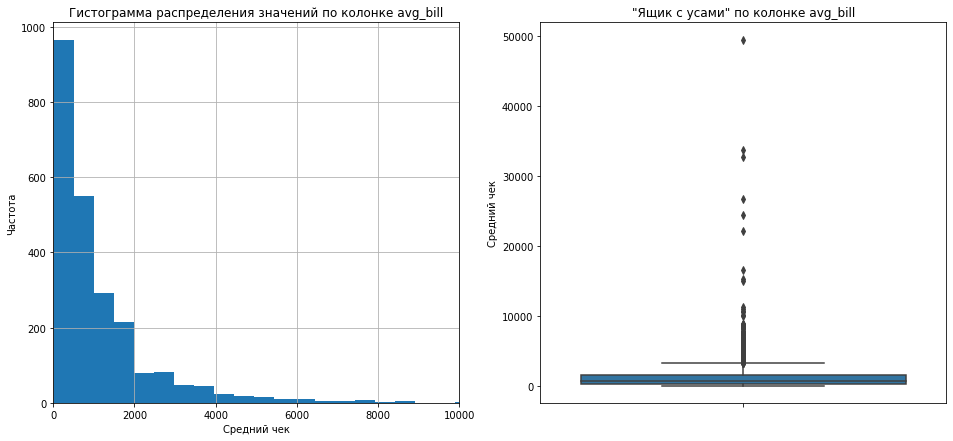

Статистические показатели по колонке avg_bill


,avg_bill
count,2393.000000
mean,1226.452690
std,2160.918072
min,14.000000
25%,292.000000
50%,674.000000
75%,1457.000000
max,49432.000000


In [57]:
get_stats(customers, 'avg_bill', 'Средний чек', bins=100, h_lim=[0, 10000], b_lim=None)

На гистограмме и на графике "ящика с усами" мы видим наличие сильных выбросов. `50%` клиентов имеют средний чек не более `674 руб`, а не более `75%` клиентов имеют средний чек менее `1457 руб`. Максимальный размер среднего чека достигает `49432 руб`.

Исходя из полученных данных можно разделить сегменты по границам перцентилей:
- сегмент со средним чеком менее `200 руб`;
- сегмент со средним чеком от `200 до 700 руб`;
- сегмент со средним чеком от `700 до 1500 руб`;
- сегмент со средним чеком свыше `1500 руб`.

Создадим колонку и запишем в нее значения сегментов при помощи созданной ранее функции `save_segment()`.

In [58]:
# сохраним в переменной границы сегментов
segments = [200, 700, 1500]

# запишем сегменты для каждого клиента
customers['avg_bill_seg'] = customers['avg_bill'].apply(lambda x: save_segment(x, segments))

Посчитаем какое количество клиентов оказалось в каждом сегменте.

In [59]:
customers.groupby('avg_bill_seg')['customer_id'].count().to_frame()

,customer_id
avg_bill_seg,
200 - 700,774
700 - 1500,597
< 200,446
> 1500,576


Визуализируем доли сегмента.

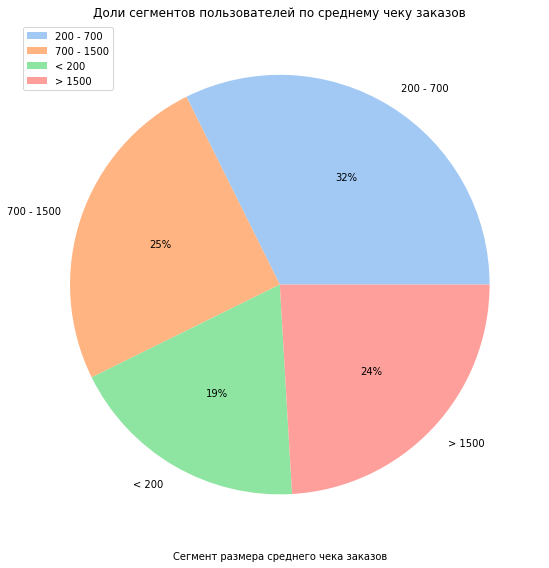

In [60]:
# создадим таблицу с количеством клиентов в сегменте
data = customers.groupby('avg_bill_seg')['customer_id'].count().to_frame().reset_index()
# зададим цветовую палитру
colors = sns.color_palette('pastel')[0:5]

# построим круговую диаграмму
plt.figure(figsize=(10, 8))
plt.pie(data['customer_id'], labels = data['avg_bill_seg'], colors=colors, autopct='%.0f%%')
plt.title('Доли сегментов пользователей по среднему чеку заказов')
plt.xlabel('Сегмент размера среднего чека заказов')
plt.legend()
plt.tight_layout()
plt.show()

<a id="s3_1"></a>

### Выводы

В процессе исследования сегментации по среднему чеку клиентов были получены следующие данные:
- `50%` клиентов имеют средний чек не более `674 руб`, а не более `75%` клиентов имеют средний чек менее `1457 руб`. 
- Максимальный размер среднего чека достигает `49432 руб`.

Пользователи были разделены на следующие сегменты в зависимости от размера среднего чека:
- сегмент со средним чеком менее `200 руб`;
- сегмент со средним чеком от `200 до 700 руб`;
- сегмент со средним чеком от `700 до 1500 руб`;
- сегмент со средним чеком свыше `1500 руб`.

В результате мы получили сегменты со следующим количеством клиентов:
- сегмент `< 200` - 446 чел.
- сегмент `200 - 700` - 774 чел.
- сегмент `700 - 1500` - 597 чел.
- сегмент `> 1500` - 576 чел.

## Сегментация по частоте оформляемых заказов

Проведем сегментацию пользователей по частоте оформляемых заказов. У нас уже посчитано общее количество совершенных заказов по каждому клиенту. Сгруппируем данные по количеству оформленных заказов и посчитаем количество пользователей.

In [61]:
# сгруппируем данные по количеству совершенных заказов
orders_count = customers.groupby('orders_count')['customer_id'].count().to_frame()

# посчитаем долю пользователей в каждой группе
orders_count['share'] = round(orders_count['customer_id'] / orders_count['customer_id'].sum(), 2)

# выведем таблицу
orders_count

,customer_id,share
orders_count,,
1,2238,0.94
2,127,0.05
3,20,0.01
4,3,0.00
5,1,0.00
7,1,0.00
17,1,0.00
35,1,0.00
126,1,0.00


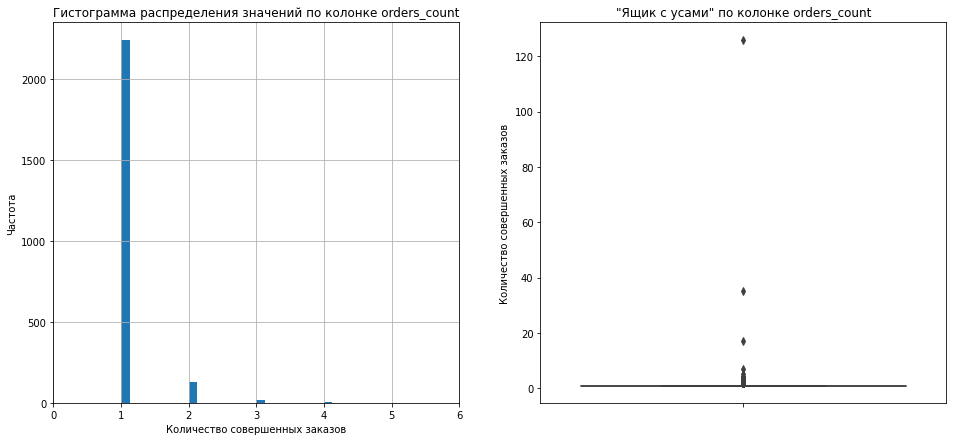

Статистические показатели по колонке orders_count


,orders_count
count,2393.000000
mean,1.150857
std,2.686874
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,126.000000


In [62]:
# построим графики распределения пользователей по количеству совершенных заказов
get_stats(customers, 'orders_count', 'Количество совершенных заказов', bins=1000, h_lim=[0, 6], b_lim=None)

Около `94%` пользователей совершили всего `1` заказ за `13 месяцев`. 
Доля пользователей совершивших более `1` заказа за `13 месяцев` составляет не более `6%`.

Исходя из полученного распределения нет необходимости высчитывать среднюю частоту заказов за более короткие периоды (месяцы и недели), т.к. `94%` пользователей совершили всего по одному заказу. Целесообразно будет разделить пользователей на 2 сегмента по количеству совершенных заказов:
- 1 заказ
- от 2 и более заказов

Сохраним сегменты в таблицу `customers`.

In [63]:
# сохраним в переменной границы сегментов
segments = [2]

# запишем сегменты для каждого клиента
customers['orders_count_seg'] = customers['orders_count'].apply(lambda x: save_segment(x, segments))

Посчитаем какое количество клиентов оказалось в каждом сегменте.

In [64]:
customers.groupby('orders_count_seg')['customer_id'].count().to_frame()

,customer_id
orders_count_seg,
< 2,2238
> 2,155


Построим круговую диаграмму с долями сегментов.

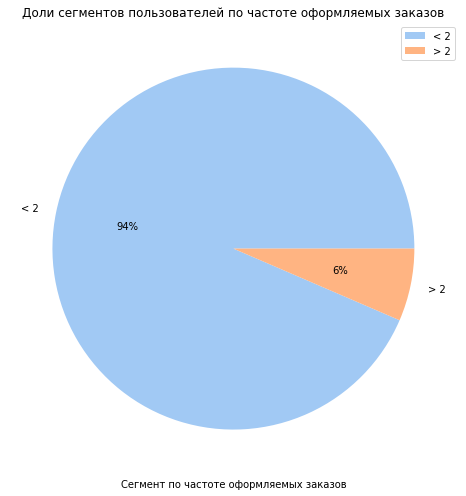

In [65]:
# создадим таблицу с количеством клиентов в сегменте
data = customers.groupby('orders_count_seg')['customer_id'].count().to_frame().reset_index()
# зададим цветовую палитру
colors = sns.color_palette('pastel')[0:5]

# построим круговую диаграмму
plt.figure(figsize=(10, 7))
plt.pie(data['customer_id'], labels = data['orders_count_seg'], colors=colors, autopct='%.0f%%')
plt.title('Доли сегментов пользователей по частоте оформляемых заказов')
plt.xlabel('Сегмент по частоте оформляемых заказов')
plt.legend()
plt.tight_layout()
plt.show()

<a id="s4_1"></a>

### Выводы

В процессе исследования сегментации по частоте оформляемых заказов были получены следующие данные:
- Около `94%` пользователей совершили всего `1` заказ за `13 месяцев`.
- Доля пользователей совершивших более `1` заказа за `13 месяцев` составляет не более `6%`.

Пользователи были разделены на следующие сегменты:
- 1 заказ (`< 2`)
- от 2 и более заказов (`> 2`)

В результате в каждом сегменте мы получили следующее количество пользователей:
- `< 2` - 2238
- `> 2` - 155

## Сегментация по давности последнего оформленного заказа

Проведем сегментацию по давности последнего оформленного заказа. Дату последнего заказа мы уже посчитали. Создадим колонку в которой мы сохраним количество дней и месяцев от последней даты заказа до последнего дня, за который имеются данные в датасете.

In [66]:
# посчитаем количество дней и месяцев от последнего оформленного заказа
customers['days_from_last_order'] = (orders['date'].max() - customers['last_order_dt']).dt.days
customers['months_from_last_order'] = round(customers['days_from_last_order'] / 30).astype('int')

# выведем  первые 5 строк таблицы
customers.head(5)

,customer_id,first_order_dt,last_order_dt,orders_count,ltv,products_count,avg_bill,avg_bill_seg,orders_count_seg,days_from_last_order,months_from_last_order
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,2019-10-16 08:00:00,1,555.0,4,555.0,200 - 700,< 2,15,0
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,2019-02-16 11:00:00,1,442.0,1,442.0,200 - 700,< 2,257,9
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,2019-10-14 23:00:00,1,914.0,1,914.0,700 - 1500,< 2,16,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,2019-01-27 17:00:00,1,1649.0,1,1649.0,> 1500,< 2,276,9
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,2019-09-29 17:00:00,1,2324.0,1,2324.0,> 1500,< 2,31,1


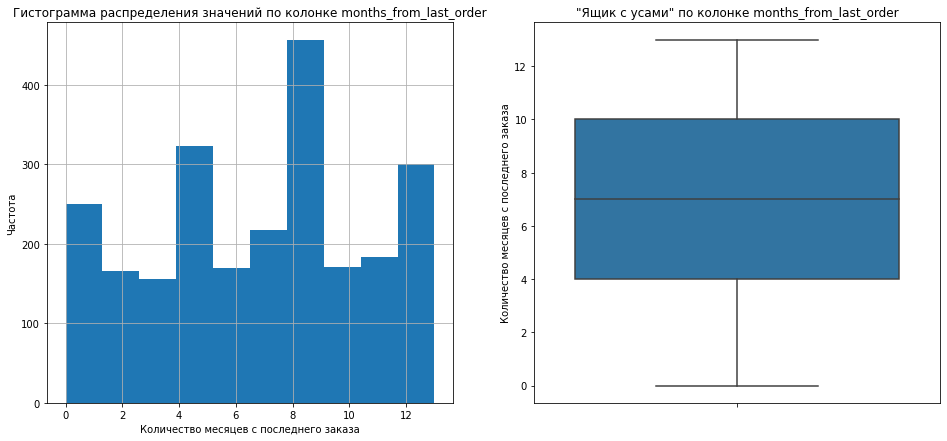

Статистические показатели по колонке months_from_last_order


,months_from_last_order
count,2393.000000
mean,6.785207
std,3.718884
min,0.000000
25%,4.000000
50%,7.000000
75%,10.000000
max,13.000000


In [67]:
# построим графики распределения пользователей по давности совершенных заказов
get_stats(customers, 'months_from_last_order', 'Количество месяцев с последнего заказа', bins=10, h_lim=None, b_lim=None)

На графиках мы видим сходство распределения по давности заказа с графиком динамики продаж.  
Около `25%` клиентов совершали последний заказ не более `4 месяцев` назад. `50%` клиентов совершил последний заказ не более `7 месяцев` назад.  
В среднем по всем клиентам последний заказ был совершен около `6 месяцев назад`. 

На гистограмме видно, что значения распределены достаточно равномерно и нет каких-либо перекосов в графике, кроме апрельского всплеска и  более меньших всплесков раз в 3 месяца.<br>
В качестве сегментации по давности покупки можно использовать колонку с количеством месяцев прошедших с последней покупки, а после проведения маркетинговых мероприятий изучить необходимость более крупной сегментации по давности покупки.

Визуализируем доли сегментов. 

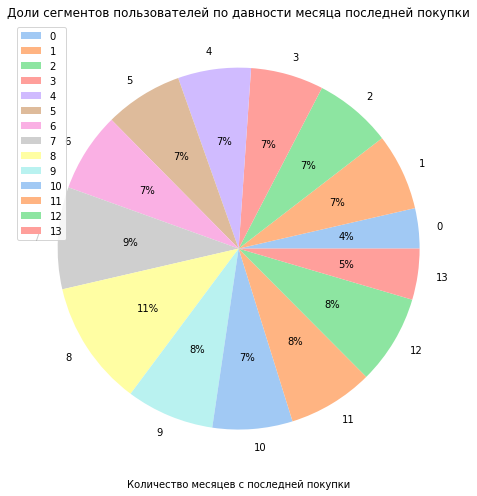

In [68]:
# создадим таблицу с количеством клиентов в сегменте
data = customers.groupby('months_from_last_order')['customer_id'].count().to_frame().reset_index()
# зададим цветовую палитру
colors = sns.color_palette('pastel')[0:14]

# построим круговую диаграмму
plt.figure(figsize=(10, 7))
plt.pie(data['customer_id'], labels = data['months_from_last_order'], colors=colors, autopct='%.0f%%')
plt.legend()
plt.title('Доли сегментов пользователей по давности месяца последней покупки')
plt.xlabel('Количество месяцев с последней покупки')
plt.tight_layout()
plt.show()

<a id="s5_1"></a>

### Выводы

Исходя из данных за имеющийся период видно, что клиенты практически не возвращаются за покупками или же повторные покупки имеют сезонный характер.  
Возможность разделить клиентов по давности покупки может позволить нам проводить стимулирующие маркетинговые мероприятия для увеличения повторных покупок.  

## Сегментация по кумулятивному доходу, полученному с покупателя

Проведем сегментацию по совокупному доходу с клиента. Таким образом, мы сможем более таргетировано выявлять рекомендации исходя из ценовых сегментов товаров.

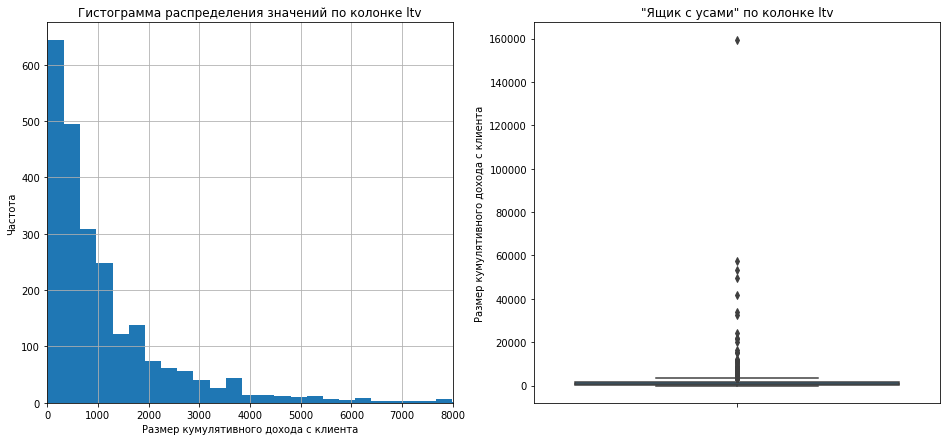

Статистические показатели по колонке ltv


,ltv
count,2393.000000
mean,1419.553698
std,4302.070543
min,14.000000
25%,299.000000
50%,710.000000
75%,1574.000000
max,159508.000000


In [69]:
# построим графики распределения пользователей по давности совершенных заказов
get_stats(customers, 'ltv', 'Размер кумулятивного дохода с клиента', bins=500, h_lim=[0, 8000], b_lim=None)

По кумулятивному доходу с клиента мы имеем большой разброс значений и сильные выбросы.  
У `25%` клиентов совокупный доход не превышает `300 руб`. У `50%` клиентов не превышает - `710 руб`, а у `75%` не превышает `1574 руб`.  
Средний размер кумулятивного дохода с клиента составляет `1419 руб`.

<a id="s6_1"></a>

### Выводы

Учитывая, что большинство клиентов совершили не более 1 заказа за имеющийся период в данных, то совокупный доход в целом будет равняться размеру чека. Мы получим те же сегменты, которые уже получили на шаге сегментирования по размеру чека.  
Для качественного сегментирования по совокупному доходу желательно взять гораздо больший период.

## Сегментация по категориям приобретаемых товаров

Для сегментации по категориям приобретаемых товаров нам необходимо определить категории товаров. Создадим отдельную талицу с товарами.

In [70]:
# создадим таблицу с продуктами
products = clean_ecom_df['product'].to_frame().drop_duplicates()

# выведем первые 10 сстрок таблицы
products.head(10)

,product
0,Пеларгония зональная диам. 12 см темнорозовая полумахровая
1,Пеларгония розебудная Queen Ingrid укорененный черенок
2,Пеларгония розебудная Rosebud Red d-7 см
3,Пеларгония тюльпановидная EMMA
4,Сушилка для белья потолочная ЛИАНА ЛЮКС 150 см ЛЛП-150
5,"Ткань для окон Duo для влажной и сухой чистки 200*200 мм, Leifheit, 40002"
6,Сумка-тележка 2-х колесная складная Gimi Flexi серая
7,Стеллаж для обуви TELIO-370 венге OPT-370V
8,Вешалка-перекладина Valiant металлическая двойная с антискользящим покрытием 50320
9,"Штора для ванной комнаты Quadretto 240х200 см белая, Bacchetta, 4062"


По наименованиям товаров можно заметить, что тип товара определяется первыми словами в названии. Попробуем создать колонки  в  таблице с продукатми, в которых мы сохраним первое слово из наименования и первые 2 слова.

In [71]:
# сохраним в отдельных колонках первое слово из наименования и первые 2 слова
products['c1'] = products['product'].apply(lambda x: x.split(' ')[0])
products['c2'] = products['product'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

Посчитаем количество значений в обеих колонках.

In [72]:
products['c1'].value_counts().to_frame()

,c1
Рассада,175
Сушилка,112
Сумка-тележка,83
томата,73
Коврик,72
...,...
Бадан,1
Ель,1
Антинакипин,1
Наматрацник,1


In [73]:
products['c2'].value_counts().to_frame()

,c2
Сушилка для,109
томата (помидор),73
Гладильная доска,69
Рассада зелени,68
Сумка-тележка хозяйственная,60
...,...
Кондиционер для,1
Фиксатор-шар хром,1
Лопатка Attribute,1
Аквилегия махровая,1


В колонке с первым словом из названия у нас получилось `461 группа` товаров, а во второй колонке - `933 группы`.

На первый взгляд, категории в первой колонке неплохо отражают тип товара и делят товары на меньшее количество групп. Воспользуемся для группировки первой колонкой.

Добавим в датасет с информацией о клиентах и содержимым заказов категории товаров.

In [74]:
clean_ecom_df = clean_ecom_df.merge(products[['product', 'c1']], on='product', how='left')

Сгруппируем данные по клиентам и категориям товаров.

In [75]:
# группируем данные по клиентам и количеству купленных товаров по категориям
customers_by_products = (
    clean_ecom_df.groupby(['customer_id', 'c1'])['order_id']
    .count()
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
)

# оставляем самую первую категорию товаров для клиента
customers_by_products = customers_by_products.drop_duplicates(subset='customer_id', keep='first')

# выведем первые 5 строк таблицы
customers_by_products.head(5)

,customer_id,c1,order_id
0,d3b9ffea-d143-4747-8d59-74ab843d1ad6,томата,40
1,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,томата,31
2,4f424a7c-3563-4316-b21f-1a65601226b2,Рассада,23
3,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,Рассада,22
4,eb6521ae-56e3-4a72-9ea2-e9c69701ff3f,Пеларгония,21


In [76]:
# объединим категории с итоговой таблицей по клиентам
customers = customers.merge(customers_by_products[['customer_id', 'c1']], on='customer_id', how='left')

# переименуем  каленкоу с категорией товара
customers = customers.rename(columns={'c1': 'product_category_cat'})

# выведем первые 5 строк таблицы
customers.head(5)

,customer_id,first_order_dt,last_order_dt,orders_count,ltv,products_count,avg_bill,avg_bill_seg,orders_count_seg,days_from_last_order,months_from_last_order,product_category_cat
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,2019-10-16 08:00:00,1,555.0,4,555.0,200 - 700,< 2,15,0,Пеларгония
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,2019-02-16 11:00:00,1,442.0,1,442.0,200 - 700,< 2,257,9,Сушилка
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,2019-10-14 23:00:00,1,914.0,1,914.0,700 - 1500,< 2,16,1,Ткань
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,2019-01-27 17:00:00,1,1649.0,1,1649.0,> 1500,< 2,276,9,Сумка-тележка
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,2019-09-29 17:00:00,1,2324.0,1,2324.0,> 1500,< 2,31,1,Стеллаж


Посчитаем сколько категорий товаров у нас получилось в итоговой таблице.

In [77]:
len(customers['product_category_cat'].unique())

342

<a id="s7_1"></a>

### Выводы

Была произведена категоризация клиентов по наиболее часто приобретаемым категориям товаров, что позволит создавать более таргетированные предложения, основанные на предпочтениях клиента и его истории покупок.  
В результате клиенты были разделены на `342` категории товаров.

## Проверка гипотез

По итогам исследования мы получили несколько разных вариантов сегментирования клиентов. Изучим насколько отличаются основные показатели внутри некоторых сегментов. Для этого проверим следующие гипотезы:
1. **Средний чек клиентов, покупающих товары для дома, не равен среднему чеку клиентов, покупающих товары для сада.**
2. **Среднее количество приобретаемых товаров в заказе различается среди сегментов клиентов, которые делали заказы менее 2 раз и тех, кто делал заказы 2 и более количество раз.**

### Гипотеза №1. Средний чек клиентов, покупающих товары для дома, не равен среднему чеку клиентов, покупающих товары для сада

Построим график для сравнения распределения значений двух выборок и изучим наличие сильных выбросов в них.

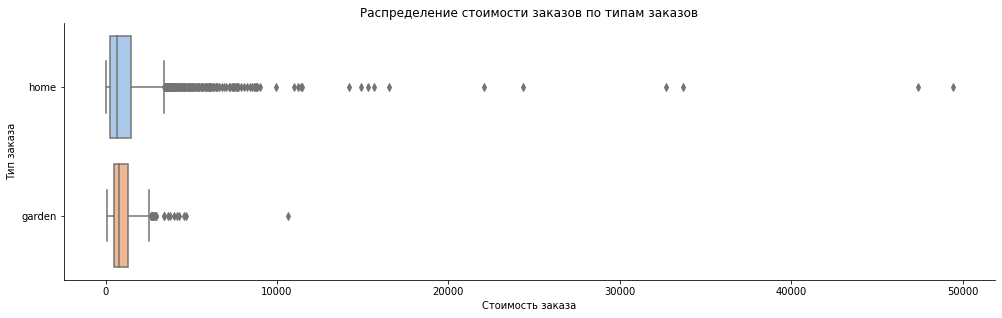

In [78]:
# построим горизонтальный "ящик с усами" по каждому типу заказа
g = sns.catplot(y='order_type', x='total_costs', kind="box", data=orders, orient='h', palette = 'pastel')
g.fig.set_figwidth(16)
g.fig.set_figheight(4)
plt.title('Распределение стоимости заказов по типам заказов')
plt.xlabel('Стоимость заказа')
plt.ylabel('Тип заказа')
plt.show()

Для заказов с товарами для дома мы видим сильные выбросы. Для корректного ссравнения выборок стоит изббавиться от сильных выбросов, которы оказывают влияние на среднее значение выборки.

Рассчитаем `95` и `99` перцентили для выборок, чтобы определить допустимые границы выбросов.

In [79]:
# создадим список с интересующими перцентилями
percentiles = [95, 99]

# выведем перцентили для каждого типа заказа
for order_type in ['home', 'garden']:
    print(order_type)
    print((
        np.percentile(orders[orders['order_type'] == order_type]
                      .groupby('order_id')['total_costs']
                      .sum(), 
                      percentiles)
    ))

home
[4044.05 8166.67]
garden
[2775.25 4301.84]


Мы получили значения, которые находятся на `95` и `99` перцентиле. Для сравнения выборок избавимся от выбросов, которые находятся выше `99` перцентиля при формировании сэмплов для теста.

Сформулируем нулевую и альтернативную гипотезы:<br>
**H0**: Средний чек клиентов, покупающих товары для дома, равен среднему чеку клиентов, покупающих товары для сада<br>
**H1**: Средний чек клиентов, покупающих товары для дома, не равен среднему чеку клиентов, покупающих товары для сада

С помощью метода `ttest_ind()` проведем статистический анализ средних чеков для заказов с товарами для дома и для заказов с товарами для сада. Параметр `alpha` примем равным `0.05`.

In [80]:
# зададим уровень порога значимости alpha
alpha = .05

# сохраним выборки
sample1 = (
    orders[np.logical_and(orders['order_type'] == "home",
                          orders['total_costs'] < 8166.67)]
    .groupby('order_id')['total_costs']
    .sum()
)
sample2 = (
    orders[np.logical_and(orders['order_type'] == "garden",
                          orders['total_costs'] < 4301.84)]
    .groupby('order_id')['total_costs']
    .sum()
)

# посчитаем значение p-value
results = st.ttest_ind(sample1, sample2)

# выведем полученное значение  p-value
print('p-value равен: {}'.format(results.pvalue, 5))

# выведем результат теста
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value равен: 0.141992535390697
Не получилось отвергнуть нулевую гипотезу


Мы не смогли получить статистически значимых различий между двумя выборками. Соотвтетсвенно, мы не можем принять нашу изначальную гипотезу о неравенстве средних чеков между заказами разных типов.

Выведем значение среднего чека по каждой выборке.

In [81]:
print('Средний чек для заказов с товарами для дома: {}'.format(round(sample1.mean(), 2)))
print('Средний чек для заказов с товарами для сада: {}'.format(round(sample2.mean(), 2)))

Средний чек для заказов с товарами для дома: 1096.01
Средний чек для заказов с товарами для сада: 984.63


Видно, что больших различий между средними чеками по типам заказов не присутствует, соответственно, у нас нет оснований считать, что средние чеки по типам заказов различаются.

### Гипотеза №2. Среднее количество приобретаемых товаров в заказе различается среди сегментов клиентов, которые делали заказы менее 2 раз и тех, кто делал заказы 2 и более количество раз

Для проведения статистического анализа сравним распределения значений двух выборок по двум сегментам.

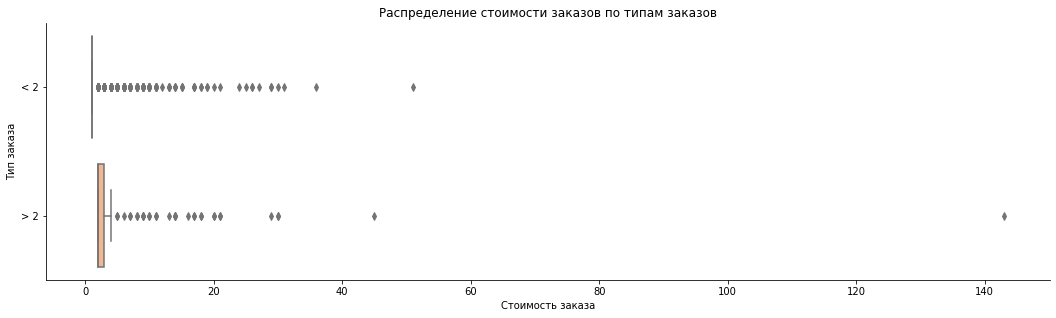

In [82]:
# построим горизонтальный "ящик с усами" по каждому сегменту
g = sns.catplot(y='orders_count_seg', x='products_count', kind="box", data=customers, orient='h', palette = 'pastel')
g.fig.set_figwidth(16)
g.fig.set_figheight(4)
plt.title('Распределение стоимости заказов по типам заказов')
plt.xlabel('Стоимость заказа')
plt.ylabel('Тип заказа')
plt.show()

На графиках видны сильные выбросы для обоих сегментов. Посчитаем перцентили.

In [83]:
# создадим список с интересующими перцентилями
percentiles = [95, 99]

# выведем перцентили для каждого сегмента
for segment in list(customers['orders_count_seg'].unique()):
    print(segment)
    print((
        np.percentile(customers[customers['orders_count_seg'] == segment]
                      .groupby('customer_id')['products_count']
                      .mean(), 
                      percentiles)
    ))

< 2
[ 6. 15.]
> 2
[20.  36.9]


Учтем полученные границы при формировании сэмплов для теста. Отбрасывать будем среднее количество товаров в заказе выше `99` перцентиля.

Сформулируем нулевую и альтернативную гипотезы:<br>
**H0**: Среднее количество приобретаемых товаров в заказе равно среди сегментов клиентов, которые делали заказы менее 2 раз и тех, кто делал заказы 2 и более количество раз<br>
**H1**: Среднее количество приобретаемых товаров в заказе не равно среди сегментов клиентов, которые делали заказы менее 2 раз и тех, кто делал заказы 2 и более количество раз

С помощью метода `ttest_ind()` проведем статистический анализ среднего количества товаров в заказе между сегментами с клиентами, совершивших менее 2-х заказов, и клиентами, совершивших 2 и более заказа. Параметр `alpha` примем равным `0.05`.

In [84]:
# зададим уровень порога значимости alpha
alpha = .05

# сохраним выборки
sample1 = (
    customers[np.logical_and(customers['orders_count_seg'] == "< 2",
                          customers['products_count'] < 15)]
    .groupby('customer_id')['products_count']
    .mean()
)
sample2 = (
    customers[np.logical_and(customers['orders_count_seg'] == "> 2",
                          customers['products_count'] < 36)]
    .groupby('customer_id')['products_count']
    .mean()
)

# посчитаем значение p-value
results = st.ttest_ind(sample1, sample2)

# выведем полученное значение  p-value
print('p-value равен: {}'.format(results.pvalue, 5))

# выведем результат теста
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value равен: 1.0455364871466904e-58
Отвергаем нулевую гипотезу


Мы получили слишком низкое значение `p-value`, поэтому мы отклоняем нулевую гипотезу и принимаем гипотезу о неравенстве среднего количества товаров в заказах между двумя сегментами.

Выведем средние значения выборок.

In [85]:
print('Среднее количество товаров в заказе для клиентов, совершивших менее 2-х заказов: {}'.format(round(sample1.mean(), 2)))
print('Среднее количество товаров в заказе для клиентов, совершивших 2 и более заказов: {}'.format(round(sample2.mean(), 2)))

Среднее количество товаров в заказе для клиентов, совершивших менее 2-х заказов: 1.5
Среднее количество товаров в заказе для клиентов, совершивших 2 и более заказов: 4.54


Видно, что средние значения сильно отличаются у двух сегментов. Клиенты с большим количеством товаров в заказе более склонны совершать повторные заказы в интернет-магазине.

<a id="s8_1"></a>

### Выводы

На данном шаге мы изучили выборки, избавились от выбросов, сформулировали и проверили 2 гипотезы:
- Гипотеза №1 была отклонена, т.к. мы не смогли получить статистических различий в среднем чеке между теми, кто приобретает товары для дома и теми, кто приобретает товары для сада.
- Мы приняли гипотезу №2, т.к. получили статистически значимые различия в среднем количестве товаров в заказах между сегментами с клиентами, совершивших менее 2-х заказов, и клиентами, совершивших 2 и более заказа.

Исходя из полученных результатов можно сделать следующие выводы:
- Нет оснований думать, что клиенты, которые покупают товары для дома приносят в среднем с заказа нам больше или меньше денег, чем клиенты, которые приобретают товары для сада.
- С большой вероятностью мы можем полагать, что клиенты, которые совершают заказы, в среднем состоящие из 4-х единиц товара, более склонны к повторным покупкам в будущем.

## Итоговые выводы

Изначально в датасете у нас имелось `6737` записей о заказанных товарах. После предобработки данных были выявленны дубли заказов, которые были с одним и тем же номером, но были зарегистрированы в разные дни. Так же были случаи когда один и тот же номер заказа был зарегистрирован для разных клиентов. По таким ситуациям неоходима дополнительная консультация с менеджерами интернет-магазина и  технической поддержкой, для выяснения причин возникновения таких ситуаций. В ходе анализа такие дубли были исключены из анализа, после чего в датасете осталось `4807` записей. После группировки данных по заказам мы получили новые дубли, в которых один и тот же заказ повторялся несколько раз и  при этом могло меняться содержимое заказа, а могло и оставаться неизменным. Их мы тоже убрали из исследования, но по таким случаям тоже необходима обратная связь от тех.поддержки.
<br>
<br>
В датасете представлены данные о заказах оформленных с `1 октября 2018` по `31 октября 2019` года.
<br>
<br>
Общее количество заказов в датасете составило `2755` штук, а количество покупателей - `2394` человек.
<br>
<br>
Было выявлено, что заказы ID которых меньше `50000` относятся к заказам для тех, кто увлекается садоводством, а заказы с ID выше `50000` - к заказам для тех, кто покупает товары для дома.
<br>
Доля заказов товаров для садоводов составляет `9%` от общих продаж, а заказов для товаров для дома составляет `91%` от ощих продаж.
<br>
<br>
В ходе исследовательского анализа была получена следующая информация:
- Не менее `75%` содержимого заказов приобретается в размере `1` штуки.
- Средняя цена единицы наименования из заказа составляет `514 руб`. Стоимость половины наименований из заказов не  превышает `150 руб`, а стоимость `75%` наименований не превышает `488 руб`.
- `75%` заказов состоит из `1` товара. Наибольшее количество товаров в заказе равно `51`.
- Более половины заказов состоит из `1` единицы товара.
- Средняя стоимость заказа составляет `1478 руб`. Около половины заказов не превышает `680 руб`, а около `75%` заказов не превышает `1461 руб`.
- Общий средний чек равен `1233 руб`. Средний чек для товаров для дома составил `1255 руб`., а для товаров для садоводов - `1051 руб`.
- В среднем один клиент совершает `1.15` заказов за 13 месяцев. Садоводы делают чуть больше заказов - в среднем `1.17`, а те, кто покупает товары для дома `1.15` заказов за 13 месяцев.

С помощью графика мы изучили динамику заказов по месяцам. Исходя из графика продажи за год сильно упали с `351000 руб` до `206000 руб`.
<br>
Заметно сильное падение продаж в январе до `230000 руб`, после чего продажи немного выросли до `315000 руб` в апреле. С апреля же заметно стабильное падение продаж, что может быть связано с летним сезоном.<br>
После изучения динамики продаж в разрезе типов заказов ("товары для садоводов" и "товары для дома") стало заметно, что увеличение продаж с апреля месяца связано с увеличением активности садоводов, т.к. в апреле-мае начинается сезон садоводства. По продаже товаров для дома заметен тренд спада продаж, что может быть связано с тем, что заметное увеличение роста продаж товаров для дома приходится на самый конец года, в период праздников.
<br>
<br>
**Сегментация по среднему чеку**
<br>
В процессе исследования сегментации по среднему чеку клиентов были получены следующие данные:
- `50%` клиентов имеют средний чек не более `674 руб`, а не более `75%` клиентов имеют средний чек менее `1457 руб`. 
- Максимальный размер среднего чека достигает `49432 руб`.

Пользователи были разделены на следующие сегменты в зависимости от размера среднего чека:
- сегмент со средним чеком менее `200 руб`;
- сегмент со средним чеком от `200 до 700 руб`;
- сегмент со средним чеком от `700 до 1500 руб`;
- сегмент со средним чеком свыше `1500 руб`.

В результате мы получили сегменты со следующим количеством клиентов:
- сегмент `< 200` - 446 чел.
- сегмент `200 - 700` - 774 чел.
- сегмент `700 - 1500` - 597 чел.
- сегмент `> 1500` - 576 чел.

**Сегментация по частоте оформляемых заказов**
<br>
В процессе исследования сегментации по частоте оформляемых заказов были получены следующие данные:
- Около `94%` пользователей совершили всего `1` заказ за `13 месяцев`.
- Доля пользователей совершивших более `1` заказа за `13 месяцев` составляет не более `6%`.

Пользователи были разделены на следующие сегменты:
- 1 заказ (`< 2`)
- от 2 и более заказов (`> 2`)

В результате в каждом сегменте мы получили следующее количество пользователей:
- `< 2` - 2238
- `> 2` - 155

**Сегментация по давности последнего оформленного заказа**
<br>
Исходя из данных за имеющийся период видно, что клиенты практически не возвращаются за покупками или же повторные покупки имеют сезонный характер.  
Возможность разделить клиентов по давности покупки может позволить нам проводить стимулирующие маркетинговые мероприятия для увеличения повторных покупок.  
На данном этапе можно в качестве сегментации по давности покупки использовать колонку с количеством месяцев прошедших с последней покупки, а после проведения маркетинговых мероприятий изучить необходимость более крупной сегментации по давности покупки.
<br>
<br>
**Сегментация по кумулятивному доходу, полученному с покупателя**
<br>
Учитывая, что большинство клиентов совершили не более 1 заказа за имеющийся период в данных, то совокупный доход в целом будет равняться размеру чека. Мы получим те же сегменты, которые уже получили на шаге сегментирования по размеру чека.  
Для качественного сегментирования по совокупному доходу желательно взять гораздо больший период.
<br>
<br>
**Сегментация по категориям приобретаемых товаров**
<br>
Была произведена категоризация клиентов по наиболее часто приобретаемым категориям товаров, что позволит создавать более таргетированные предложения, основанные на предпочтениях клиента и его истории покупок.  
В результате клиенты были разделены на `342` категории товаров.

**Проверка гипотез**
<br>
<br>
В ходе исследования было сформулировано 2 гипотезы:
1. **Средний чек клиентов, покупающих товары для дома, не равен среднему чеку клиентов, покупающих товары для сада.**
2. **Среднее количество приобретаемых товаров в заказе различается среди сегментов клиентов, которые делали заказы менее 2 раз и тех, кто делал заказы 2 и более количество раз.**

<br>
После статистической проверки гипотез мы получили следующие результаты:
- Гипотеза №1 была отклонена, т.к. мы не смогли получить статистических различий в среднем чеке между теми, кто приоббретает товары для дома и теми, кто приобретает товары для сада.
- Мы приняли гипотезу №2, т.к. смогли получили статистически значимые различия в среднем количестве товаров в заказах между сегментами с клиентами, совершивших менее 2-х заказов, и клиентами, совершивших 2 и более заказа.


Исходя из полученных результатов можно сделать следующие выводы:

- Нет оснований думать, что клиенты, которые покупают товары для дома приносят в среднем с заказа нам больше или меньше денег, чем клиенты, которые приобретают товары для сада.
- С большой вероятностью мы можем полагать, что клиенты, которые совершают заказы, в среднем состоящие из 4-х единиц товара, более склонны к повторным покупкам в будущем.

### Рекомендации <a id="s9_1"></a>

На основании полученных сегментов рекомендуется провести стимулирующие маркетинговые мероприятия с целью увеличения повторных покупок клиентами, уже совершавшими хотя бы одну покупку в интернет-магазине.
<br>
<br>
В полученной итоговой таблице с клиентами мы имеем возможность сегментировать их по количеству совершенных покупок, что позволит проводить e-mail рассылки с акционными и индивидуальными предложениями для стимуляции к повторной покупке. С помощью сегментов часто покупаемых категорий товаров можно акционные предложения делать более таргетированными. Дополнительно можно изучить категории допродаж и сопутствующих товаров, чтобы предлагать новый ассортимент на основе старых покупок.
<br>
<br>
Помимо стимулирующих мероприятий можно проводить мероприятия по увеличению лояльности, предлагать специальные выгодные предложения для тех, кто оформлял заказы более 2-3 раз в интернет-магазине.
<br>
<br>
У нас имеется сегментация по давности последней покупки, что позволяет нам делать рассылки с целью напомнить о себе и об актуальных акционных предложениях интернет-магазина.
<br>
<br>
Сегментация по среднему чеку позволит нам предлагать сопутствующие товары для клиентов с низким средним чеком, что позволит влиять на увеличение общего среднего чека.